In [2]:
#@title Imports

import torch
import argparse
import os
import numpy as np
from torchvision import transforms
from utils import *
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
import copy
from datasets.load import load_from_disk

In [3]:
#@title Util Functions
def load_model(model_path, device):
    model = torch.load("./results/" + os.path.join(model_path + '.pth'), map_location=device)
    model.eval()
    return model

def predict_image(model, image_path, device):
    image = Image.open(image_path).convert('RGB')
    
    transform = A.Compose([
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2()
    ])

    image = transform(image=np.array(image))['image']
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        return output, image

def save_prediction(output, save_path):
    plt.imshow(output.squeeze().cpu().numpy(), cmap='gray')
    plt.axis('off')
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0)
    

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

imsize = 512 if torch.cuda.is_available() else 256  

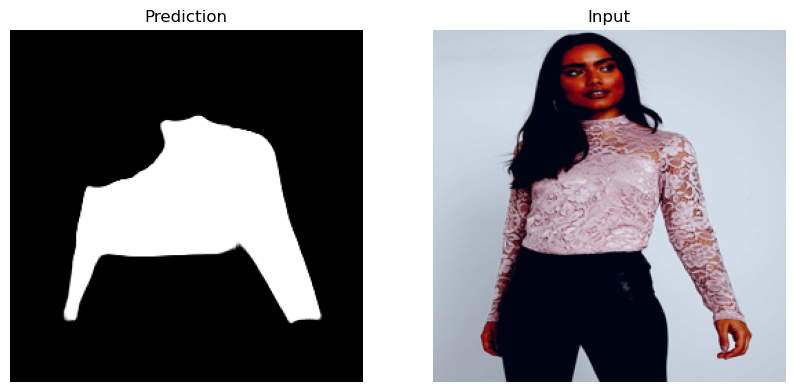

In [4]:
MODEL_PATH = "final_best_model"
IMAGE_PATH = "test.png"
SAVE_DIR = "predictions"

device = 'cpu'
model = load_model(MODEL_PATH, device)

segmentation_image, input = predict_image(model, IMAGE_PATH, device)

if not os.path.exists(SAVE_DIR):
    os.makedirs(SAVE_DIR)


IMAGE_PATH = IMAGE_PATH[:-4]

#save_path = SAVE_DIR + "/" + os.path.basename(IMAGE_PATH) + '_prediction.png'
#save_prediction(segmentation_image, save_path)
input = input - input.min()
input = input / input.max()

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(segmentation_image.squeeze().cpu().numpy(), cmap='gray')
plt.title('Prediction')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(input.squeeze().cpu().numpy().transpose(1,2,0))
plt.title('Input')
plt.axis('off')
plt.show()

In [5]:
loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor()])  


input2 = transforms.ToPILImage()(input.squeeze().cpu())
content_img = loader(input2).unsqueeze(0)
content_img = content_img.to(device, torch.float)

style_image = plt.imread('texture.jpg')
style_image = Image.fromarray(style_image)
style_image = loader(style_image).unsqueeze(0)
style_img = style_image.to(device, torch.float)

segmentation_image2 = transforms.ToPILImage()(segmentation_image.squeeze().cpu())
mask = loader(segmentation_image2).unsqueeze(0)
mask = mask.to(device, torch.float)
th = 0.5
mask[mask > th] = 1
mask[mask <= th] = 0


In [7]:
unloader = transforms.ToPILImage()  

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)     
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(1)


class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()

    features = input.view(a * b, c * d) 

    G = torch.mm(features, features.t())

    return G.div(a * b * c * d)


class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
    

cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):

        return (img - self.mean) / self.std
    


content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0  
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
       
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
   
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

  
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

input_img = content_img.clone()


def get_input_optimizer(input_img):
    
    optimizer = optim.LBFGS([input_img])
    return optimizer


def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=700,
                       style_weight=1000000, content_weight=25):
    
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

   
    input_img.requires_grad_(True)
   
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img


output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
output = output * mask + (content_img * (1 - mask))

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 71.860268 Content Loss: 281.215881

run [100]:
Style Loss : 41.106747 Content Loss: 199.610001

run [150]:
Style Loss : 37.181267 Content Loss: 184.079498

run [200]:
Style Loss : 35.415829 Content Loss: 178.269775

run [250]:
Style Loss : 34.481709 Content Loss: 175.456238

run [300]:
Style Loss : 33.866562 Content Loss: 173.846558

run [350]:
Style Loss : 33.474930 Content Loss: 172.777115

run [400]:
Style Loss : 33.176212 Content Loss: 172.093307

run [450]:
Style Loss : 32.969017 Content Loss: 171.565277

run [500]:
Style Loss : 32.846024 Content Loss: 171.125473

run [550]:
Style Loss : 32.729851 Content Loss: 170.793167

run [600]:
Style Loss : 32.629074 Content Loss: 170.519440

run [650]:
Style Loss : 32.523712 Content Loss: 170.302612

run [700]:
Style Loss : 32.449490 Content Loss: 170.080536



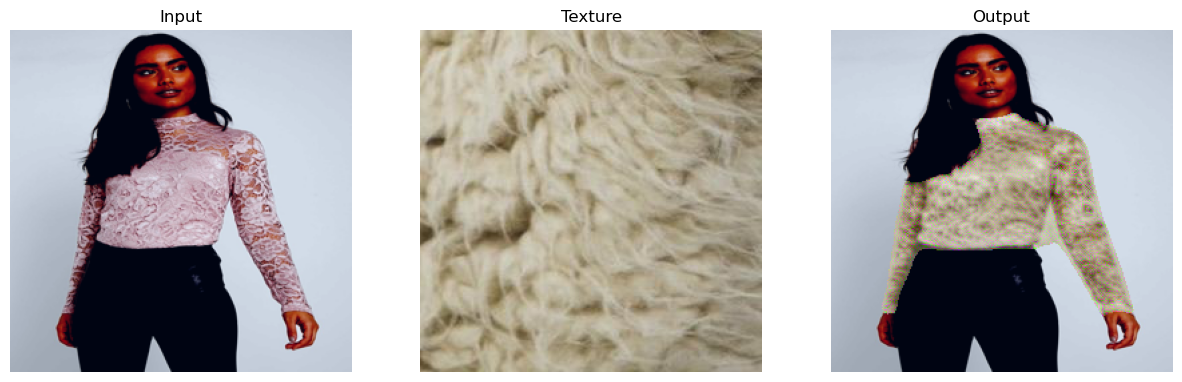

In [71]:
plt.figure(figsize=(15,10))
plt.subplot(1,3,1)
plt.imshow(unloader(content_img.cpu().squeeze(0)))
plt.title('Input')
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(unloader(style_img.cpu().squeeze(0)))
plt.title('Texture')
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(unloader(output.cpu().squeeze(0)))
plt.title('Output')
plt.axis('off')
plt.show()
